TODO:


R1: 
- get in touch with ngspice developers to go over xspice's lcouple & magnetic core
- reivew the tcoil more in depth


R2:
- Get rest of standard transformer done


In [1]:
from skidl.pyspice import *
#can you say cheeky 
import PySpice as pspice
#becouse it's written by a kiwi you know
import lcapy as kiwi

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sym

from scipy.signal import zpk2tf as scipy_zpk2tf


from IPython.display import YouTubeVideo, display

import traceback
import warnings

In [2]:
#import dc code from parral folder
import sys
sys.path.insert(1, '../DC_1/')
from DC_1_Codes import get_skidl_spice_ref

from AC_2_Codes import *

sym.init_printing()

#notebook specific loading control statements 
%matplotlib inline
#tool to log notebook internals
#https://github.com/jrjohansson/version_information
%load_ext version_information
%version_information skidl, PySpice,lcapy, sympy, numpy, matplotlib, pandas, scipy

Software,Version
Python,3.7.6 64bit [GCC 7.3.0]
IPython,7.12.0
OS,Linux 4.19.104 microsoft standard x86_64 with debian bullseye sid
skidl,0.0.31.dev0
PySpice,1.4.3
lcapy,0.75.dev0
sympy,1.6.2
numpy,1.18.1
matplotlib,3.3.0
pandas,1.1.4


# Mutual Inductance and SPICE

For a recollection of the basic theory of self and mutual inductance recall the YT video on the subject below from ALL ABOUT ELECTRONICS. However, let's be clear about this right now; SPICE is not a field simulator. SPICE just does a bit more than your EE 101/102 textbook. Though we will see there are ways to enhance the basic SPICE with XSPICE to implement more advanced magnetic device models. But even with XSPICE, we can still not get to the level of field solvers like Ansys who will do full E&M simulations and then extract the S-parameters and then use that as part of its SPICE incarnation.


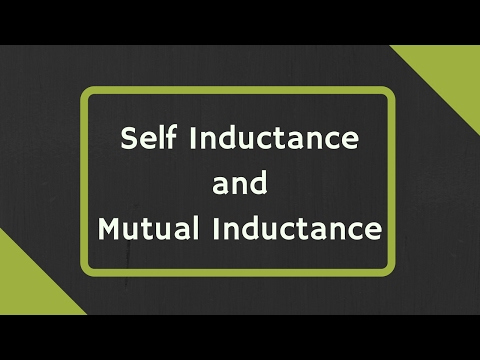

In [3]:
YouTubeVideo('hoTInTKij0o', width=500, height=400)

The other thing to recall is that inductors in reference to other inductors are polarized elements and that polarization does have consequences as explained by ALL ABOUT ELECTRONICS in the YT video "Dot Convention in Magnetically Coupled Circuits"

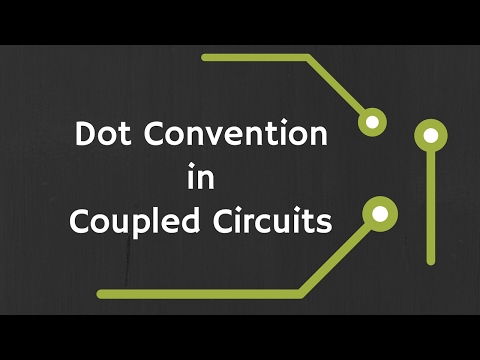

In [4]:
YouTubeVideo('sILgO4sQmRs', width=500, height=400)

Where in SPICE as we will see the dot belongs to the first terminal of the inductor. Further, to make SPICE aware of what inductors are coupled to which we use the `K` statement who’s SPICE syntax is

```
KXXXXXXX LYYYYYYY LZZZZZZZ value
```

Where `KXXXXXXX` is the name of the coupling, `LYYYYYYY` and `LZZZZZZZ` are the two inductors that are being coupled. And finally, value the value of the coefficient of coupling $k$ where $k$ can take on a value from 0 to 1 and is defined as

$$k=\dfrac{M}{\sqrt{L_Y L_Z}}$$

where $M$ is the mutual inductance between the two inductors and $L_Y$ & $L_Z$ are the values of the inductors of the two inductors respectively


# Series Mutual inductance

The following is a quick testbench to when testing mutual inductance in SPICE

In [5]:
#%%writefile -a AC_2_Codes.py
#chapteer 2 section 3 mutual_tester class
#class to perform the analysis of the coupled inductors in section 3

class mutual_tester(ac_ease, ac_representation_tool, eecomplex_plot_templets):
    """
    Quick class to test mutual inductance 
    """
    
    def __init__(self, circ, title, start_freq=1@u_Hz, stop_freq=100@u_Hz):
        """
        Quick class to test mutual inductance 
        
        Args:
            circ (pyspice circuit): circuit under test
            title (str): title for plots
            start_freq(float; Hertz; 1@u_Hz): the starting freauncy
            stop_freq(float; Hertz; 100@u_Hz): the ending freauncy
        
        Returns:
            does the ac sim of the circuit, produces the ac values transformed 
            in `self.ac_sim_mag_DF` ect and creates a bode plot of the results

        """
        
        #do what ac_ease is supposed to do at startup
        #instainte the simulation from the circuit
        ac_ease.__init__(self, circ)
        #setup the simulation parameter with the helper method
        self.ac_sweep_setup(start_freq, stop_freq, 20, 'decade', True)
        #do the simulation
        self.do_ac_sim()
        
        
        #do what ac_representation_tool is supposed to do at startup
        #and pass in the selfs from `ac_ease`'s ac_resultsNB_DF
        ac_representation_tool.__init__(self, self.ac_resultsNB_DF)
        #generate the representations
        self.make_mag_phase()
        
        
        eecomplex_plot_templets.__init__(self)


        fig, ax_bode=plt.subplots(nrows=1, ncols=1) 

        self.bode_plot_one_templet(self.ac_sim_mag_DF.index, self.ac_sim_mag_DF['V1_[A][dB]'], self.ac_sim_phase_DF['V1_[A][deg]'], 
                          title='Source_Current_Draw', ax=ax_bode)

        
        fig.suptitle(title)


For each of the examples from ALL ABOUT ELECTRONICS here will create the circuit in three ways to see what effect mutual coupling has. The first is with no coupling. The second is invoking the mutual coupling. And the third case implementing the circuit with the theoretical simplification. This is followed by plotting all three cases on top of each other to see the effect of invoking mutual coupling and the theoretical simplification from SPICE’s view. 

## Series Adding Mutual Inductance from ALL ABOUT ELECTRONICS "Mutually Coupled Inductors in Series (Derivation / Proof and Examples)" @~ 6:04min

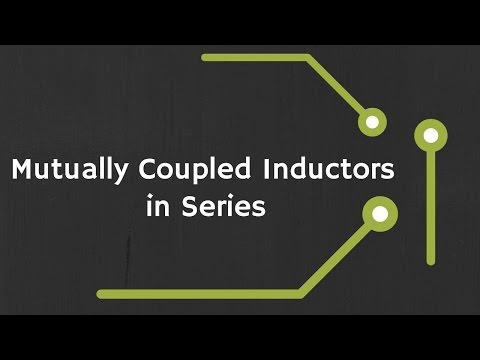

In [6]:
YouTubeVideo('49OL_3L7BFA', width=500, height=400, start=364)

### No Coupling

In [7]:
reset()
#create the nets
net_in=Net('In')

#create a 1V AC test source and dummy R and attache to nets
vs=SINEV(ac_magnitude=1@u_V)
rdummy=R(ref='dummy', value=0@u_Ohm)
vs['p', 'n']+=rdummy[1], gnd
rdummy[2]+=net_in

l1=L(value=3@u_H)
l2=L(value=3@u_H)
net_in & l1[1, 2] & l2[1, 2] & gnd

#k=K(ind1=l1, ind2=l2, coupling=0.5)


circ_nok=generate_netlist()
print(circ_nok)

.title 
V1 N_1 0 DC 0V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)
Rdummy N_1 In 0Ohm
L1 In N_2 3H
L2 N_2 0 3H




No errors or warnings found during netlist generation.



,Start_freq,Stop_Freq,SamplingInc,StepType
0,1 Hz,100 Hz,20,decade


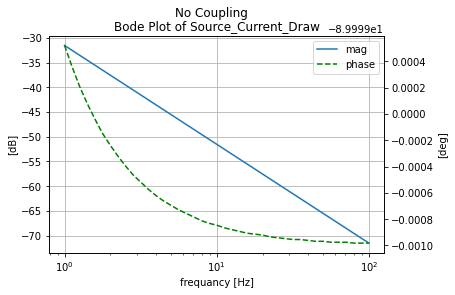

In [8]:
anylsis_nok=mutual_tester(circ_nok, 'No Coupling')

### With Coupling

In [9]:
reset()
#create the nets
net_in=Net('In')

#create a 1V AC test source and dummy R and attache to nets
vs=SINEV(ac_magnitude=1@u_V)
rdummy=R(ref='dummy', value=0@u_Ohm)
vs['p', 'n']+=rdummy[1], gnd
rdummy[2]+=net_in

l1=L(value=3@u_H)
l2=L(value=3@u_H)
net_in & l1[1, 2] & l2[1, 2] & gnd

k=K(ind1=l1, ind2=l2, coupling=0.5)


circ_k=generate_netlist()
print(circ_k)

.title 
V1 N_1 0 DC 0V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)
Rdummy N_1 In 0Ohm
L1 In N_2 3H
L2 N_2 0 3H
K1 L1 L2 0.5




No errors or warnings found during netlist generation.



,Start_freq,Stop_Freq,SamplingInc,StepType
0,1 Hz,100 Hz,20,decade


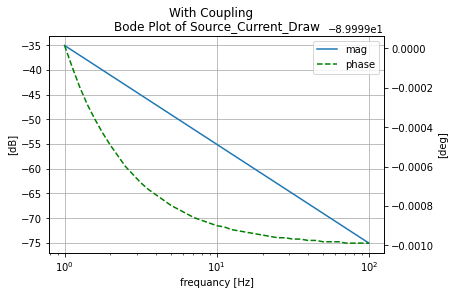

In [10]:
anylsis_k=mutual_tester(circ_k, 'With Coupling')

### Equivlint Single Inductor

In [11]:
reset()
#create the nets
net_in=Net('In')

#create a 1V AC test source and dummy R and attache to nets
vs=SINEV(ac_magnitude=1@u_V)
rdummy=R(ref='dummy', value=0@u_Ohm)
vs['p', 'n']+=rdummy[1], gnd
rdummy[2]+=net_in

l1=L(value=9@u_H)
net_in & l1[1, 2] & gnd



circ_eq=generate_netlist()
print(circ_eq)

.title 
V1 N_1 0 DC 0V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)
Rdummy N_1 In 0Ohm
L1 In 0 9H




No errors or warnings found during netlist generation.



,Start_freq,Stop_Freq,SamplingInc,StepType
0,1 Hz,100 Hz,20,decade


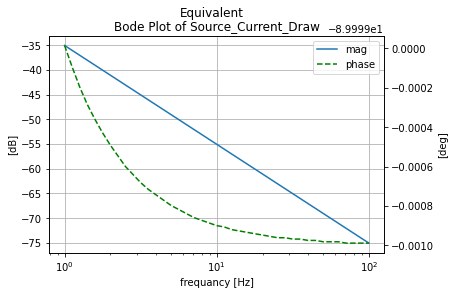

In [12]:
anylsis_eq=mutual_tester(circ_eq, 'Equivalent')

### Comperion between all three cases

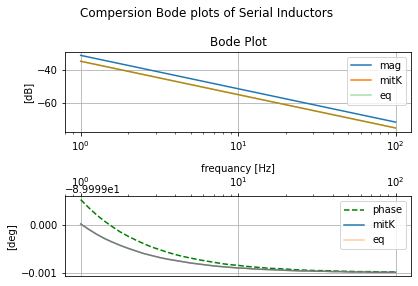

In [13]:
comp_plot=eecomplex_plot_templets()
fig, [ax_mag, ax_phase]=plt.subplots(ncols=1, nrows=2)
comp_plot.bode_plot_two_templet(anylsis_nok.ac_sim_mag_DF.index,
                               anylsis_nok.ac_sim_mag_DF['V1_[A][dB]'],
                               anylsis_nok.ac_sim_phase_DF['V1_[A][deg]'],
                        axs=[ax_mag, ax_phase]
                               )
ax_mag.semilogx(anylsis_k.ac_sim_mag_DF.index, anylsis_k.ac_sim_mag_DF['V1_[A][dB]'], label='mitK')
ax_phase.semilogx(anylsis_k.ac_sim_mag_DF.index, anylsis_k.ac_sim_phase_DF['V1_[A][deg]'], label='mitK')


ax_mag.semilogx(anylsis_eq.ac_sim_mag_DF.index, anylsis_eq.ac_sim_mag_DF['V1_[A][dB]'], alpha=.4, label="eq")
ax_phase.semilogx(anylsis_eq.ac_sim_mag_DF.index, anylsis_eq.ac_sim_phase_DF['V1_[A][deg]'], alpha=.4, label='eq')

ax_mag.legend()
ax_phase.legend()
plt.suptitle('Compersion Bode plots of Serial Inductors')
plt.tight_layout();

## Series Opposing Mutual Inductance from ALL ABOUT ELECTRONICS "Mutually Coupled Inductors in Series (Derivation / Proof and Examples)" @~ 7:17min

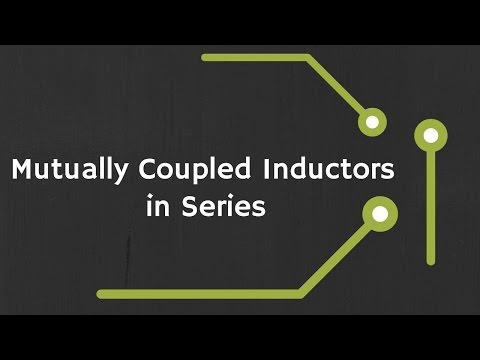

In [14]:
YouTubeVideo('49OL_3L7BFA', width=500, height=400, start=437)

### No Coupling

In [15]:
reset()
#create the nets
net_in=Net('In')

#create a 1V AC test source and dummy R and attache to nets
vs=SINEV(ac_magnitude=1@u_V)
rdummy=R(ref='dummy', value=0@u_Ohm)
vs['p', 'n']+=rdummy[1], gnd
rdummy[2]+=net_in

l1=L(value=1@u_H)
l2=L(value=4@u_H)
net_in & l1[1, 2] & l2[2, 1] & gnd

#k=K(ind1=l1, ind2=l2, coupling=0.9)


circ_nok=generate_netlist()
print(circ_nok)

.title 
V1 N_1 0 DC 0V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)
Rdummy N_1 In 0Ohm
L1 In N_2 1H
L2 0 N_2 4H




No errors or warnings found during netlist generation.



,Start_freq,Stop_Freq,SamplingInc,StepType
0,1 Hz,100 Hz,20,decade


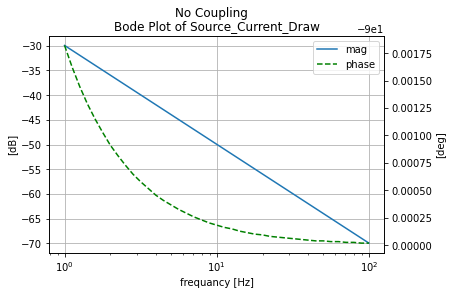

In [16]:
anylsis_nok=mutual_tester(circ_nok, 'No Coupling')

### With Coupling

In [17]:
reset()
#create the nets
net_in=Net('In')

#create a 1V AC test source and dummy R and attache to nets
vs=SINEV(ac_magnitude=1@u_V)
rdummy=R(ref='dummy', value=0@u_Ohm)
vs['p', 'n']+=rdummy[1], gnd
rdummy[2]+=net_in

l1=L(value=1@u_H)
l2=L(value=4@u_H)
net_in & l1[1, 2] & l2[2, 1] & gnd

k=K(ind1=l1, ind2=l2, coupling=0.9)


circ_k=generate_netlist()
print(circ_k)

.title 
V1 N_1 0 DC 0V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)
Rdummy N_1 In 0Ohm
L1 In N_2 1H
L2 0 N_2 4H
K1 L1 L2 0.9




No errors or warnings found during netlist generation.



,Start_freq,Stop_Freq,SamplingInc,StepType
0,1 Hz,100 Hz,20,decade


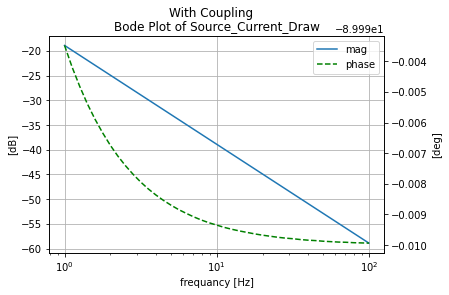

In [18]:
anylsis_k=mutual_tester(circ_k, 'With Coupling')

### Equivalent Single Inductor

In [19]:
reset()
#create the nets
net_in=Net('In')

#create a 1V AC test source and dummy R and attache to nets
vs=SINEV(ac_magnitude=1@u_V)
rdummy=R(ref='dummy', value=0@u_Ohm)
vs['p', 'n']+=rdummy[1], gnd
rdummy[2]+=net_in

l1=L(value=1.4@u_H)
net_in & l1[1, 2] & gnd



circ_eq=generate_netlist()
print(circ_eq)

.title 
V1 N_1 0 DC 0V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)
Rdummy N_1 In 0Ohm
L1 In 0 1.4H




No errors or warnings found during netlist generation.



,Start_freq,Stop_Freq,SamplingInc,StepType
0,1 Hz,100 Hz,20,decade


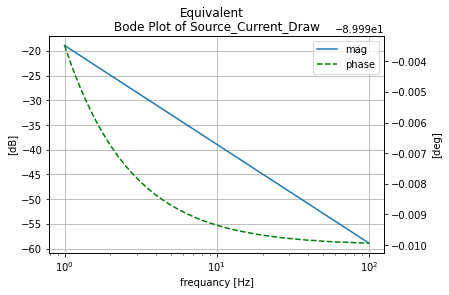

In [20]:
anylsis_eq=mutual_tester(circ_eq, 'Equivalent')

### Compersion between all three cases

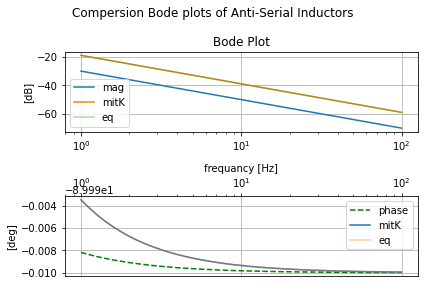

In [21]:
comp_plot=eecomplex_plot_templets()
fig, [ax_mag, ax_phase]=plt.subplots(ncols=1, nrows=2)
comp_plot.bode_plot_two_templet(anylsis_nok.ac_sim_mag_DF.index,
                               anylsis_nok.ac_sim_mag_DF['V1_[A][dB]'],
                               anylsis_nok.ac_sim_phase_DF['V1_[A][deg]'],
                        axs=[ax_mag, ax_phase]
                               )
ax_mag.semilogx(anylsis_k.ac_sim_mag_DF.index, anylsis_k.ac_sim_mag_DF['V1_[A][dB]'], label='mitK')
ax_phase.semilogx(anylsis_k.ac_sim_mag_DF.index, anylsis_k.ac_sim_phase_DF['V1_[A][deg]'], label='mitK')


ax_mag.semilogx(anylsis_eq.ac_sim_mag_DF.index, anylsis_eq.ac_sim_mag_DF['V1_[A][dB]'], alpha=.4, label="eq")
ax_phase.semilogx(anylsis_eq.ac_sim_mag_DF.index, anylsis_eq.ac_sim_phase_DF['V1_[A][deg]'], alpha=.4, label='eq')

ax_mag.legend()
ax_phase.legend()
plt.suptitle('Compersion Bode plots of Anti-Serial Inductors')
plt.tight_layout();

# Parallel Mutual Inductance

## Parallel Adding Mutual Inductance from ALL ABOUT ELECTRONICS "Mutually Coupled Inductors in Parallel (Derivation / Proof and Examples)" @~ 13:04min

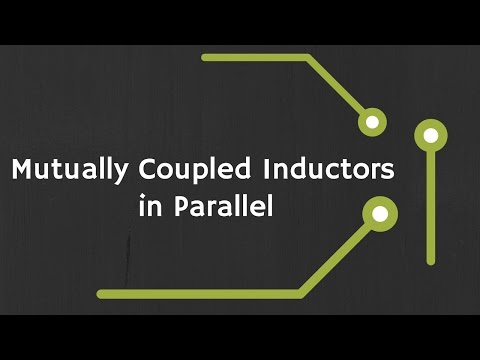

In [22]:
YouTubeVideo('NacczEJj_iI', width=500, height=400, start=784)

### No Coupling

In [23]:
reset()
#create the nets
net_in=Net('In')

#create a 1V AC test source and dummy R and attache to nets
vs=SINEV(ac_magnitude=1@u_V)
rdummy=R(ref='dummy', value=0@u_Ohm)
vs['p', 'n']+=rdummy[1], gnd
rdummy[2]+=net_in

l1=L(value=1@u_H)
l2=L(value=4@u_H)
rdummy2=R(ref='dummy', value=0@u_Ohm)

l1[1, 2]+=net_in, gnd
rdummy2[1, 2]+=l1[1], l2[1]
l2[2]+=gnd

#k=K(ind1=l1, ind2=l2, coupling=0.5)

circ_nok=generate_netlist()
print(circ_nok)

.title 
V1 N_1 0 DC 0V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)
Rdummy N_1 In 0Ohm
L1 In 0 1H
L2 N_2 0 4H
Rdummy_1 In N_2 0Ohm




No errors or warnings found during netlist generation.



,Start_freq,Stop_Freq,SamplingInc,StepType
0,1 Hz,100 Hz,20,decade


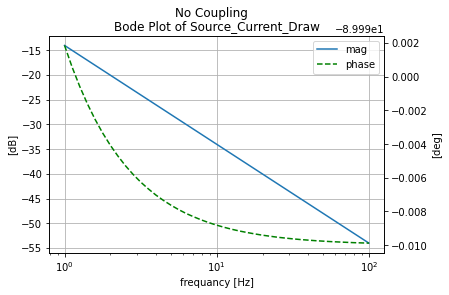

In [24]:
anylsis_nok=mutual_tester(circ_nok, 'No Coupling')

### With Coupling

In [25]:
reset()
#create the nets
net_in=Net('In')

#create a 1V AC test source and dummy R and attache to nets
vs=SINEV(ac_magnitude=1@u_V)
rdummy=R(ref='dummy', value=0@u_Ohm)
vs['p', 'n']+=rdummy[1], gnd
rdummy[2]+=net_in

l1=L(value=1@u_H)
l2=L(value=4@u_H)
rdummy2=R(ref='dummy', value=0@u_Ohm)

l1[1, 2]+=net_in, gnd
rdummy2[1, 2]+=l1[1], l2[1]
l2[2]+=gnd

k=K(ind1=l1, ind2=l2, coupling=0.5)

circ_k=generate_netlist()
print(circ_k)

.title 
V1 N_1 0 DC 0V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)
Rdummy N_1 In 0Ohm
L1 In 0 1H
L2 N_2 0 4H
Rdummy_1 In N_2 0Ohm
K1 L1 L2 0.5




No errors or warnings found during netlist generation.



,Start_freq,Stop_Freq,SamplingInc,StepType
0,1 Hz,100 Hz,20,decade


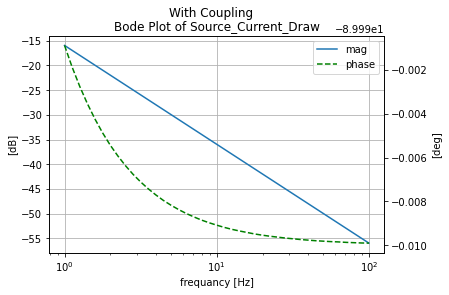

In [26]:
anylsis_k=mutual_tester(circ_k, 'With Coupling')

### Equivalent Single Inductor

In [27]:
reset()
#create the nets
net_in=Net('In')

#create a 1V AC test source and dummy R and attache to nets
vs=SINEV(ac_magnitude=1@u_V)
rdummy=R(ref='dummy', value=0@u_Ohm)
vs['p', 'n']+=rdummy[1], gnd
rdummy[2]+=net_in

l1=L(value=1@u_H)
net_in & l1[1, 2] & gnd

#k=K(ind1=l1, ind2=l2, coupling=0.5)

circ_eq=generate_netlist()
print(circ_eq)

.title 
V1 N_1 0 DC 0V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)
Rdummy N_1 In 0Ohm
L1 In 0 1H




No errors or warnings found during netlist generation.



,Start_freq,Stop_Freq,SamplingInc,StepType
0,1 Hz,100 Hz,20,decade


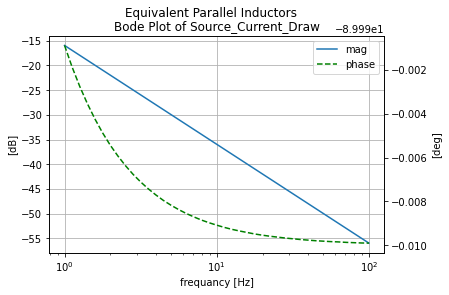

In [28]:
anylsis_eq=mutual_tester(circ_eq, 'Equivalent Parallel Inductors')

### Compersion between all three cases

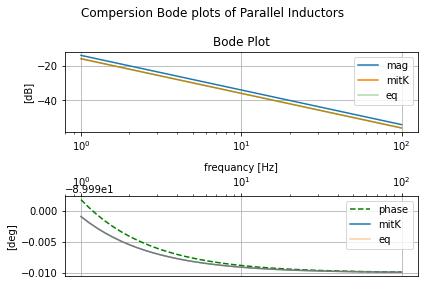

In [29]:
comp_plot=eecomplex_plot_templets()
fig, [ax_mag, ax_phase]=plt.subplots(ncols=1, nrows=2)
comp_plot.bode_plot_two_templet(anylsis_nok.ac_sim_mag_DF.index,
                               anylsis_nok.ac_sim_mag_DF['V1_[A][dB]'],
                               anylsis_nok.ac_sim_phase_DF['V1_[A][deg]'],
                        axs=[ax_mag, ax_phase]
                               )
ax_mag.semilogx(anylsis_k.ac_sim_mag_DF.index, anylsis_k.ac_sim_mag_DF['V1_[A][dB]'], label='mitK')
ax_phase.semilogx(anylsis_k.ac_sim_mag_DF.index, anylsis_k.ac_sim_phase_DF['V1_[A][deg]'], label='mitK')


ax_mag.semilogx(anylsis_eq.ac_sim_mag_DF.index, anylsis_eq.ac_sim_mag_DF['V1_[A][dB]'], alpha=.4, label="eq")
ax_phase.semilogx(anylsis_eq.ac_sim_mag_DF.index, anylsis_eq.ac_sim_phase_DF['V1_[A][deg]'], alpha=.4, label='eq')

ax_mag.legend()
ax_phase.legend()
plt.suptitle('Compersion Bode plots of Parallel Inductors')
plt.tight_layout();

## Parallel Opposing Mutual Inductance from ALL ABOUT ELECTRONICS "Mutually Coupled Inductors in Parallel (Derivation / Proof and Examples)" @~ 14:25min

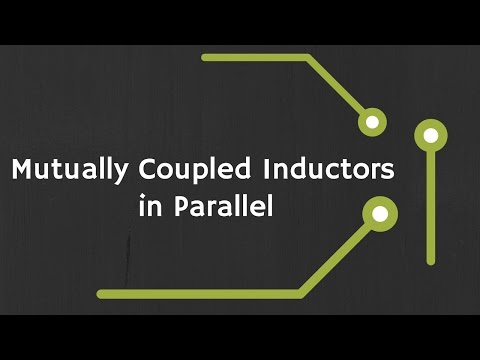

In [30]:
YouTubeVideo('NacczEJj_iI', width=500, height=400, start=865)

### No Coupling

In [31]:
reset()
#create the nets
net_in=Net('In')

#create a 1V AC test source and dummy R and attache to nets
vs=SINEV(ac_magnitude=1@u_V)
rdummy=R(ref='dummy', value=0@u_Ohm)
vs['p', 'n']+=rdummy[1], gnd
rdummy[2]+=net_in

l1=L(value=1@u_H)
l2=L(value=4@u_H)
rdummy2=R(ref='dummy', value=0@u_Ohm)

l1[1, 2]+=net_in, gnd
rdummy2[1, 2]+=l1[1], l2[2]
l2[1]+=gnd

#k=K(ind1=l1, ind2=l2, coupling=0.5)

circ_nok=generate_netlist()
print(circ_nok)

.title 
V1 N_1 0 DC 0V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)
Rdummy N_1 In 0Ohm
L1 In 0 1H
L2 0 N_2 4H
Rdummy_1 In N_2 0Ohm




No errors or warnings found during netlist generation.



,Start_freq,Stop_Freq,SamplingInc,StepType
0,1 Hz,100 Hz,20,decade


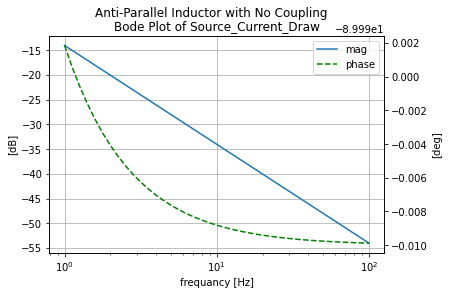

In [32]:
anylsis_nok=mutual_tester(circ_nok, 'Anti-Parallel Inductor with No Coupling')

### With Coupling

In [33]:
reset()
#create the nets
net_in=Net('In')

#create a 1V AC test source and dummy R and attache to nets
vs=SINEV(ac_magnitude=1@u_V)
rdummy=R(ref='dummy', value=0@u_Ohm)
vs['p', 'n']+=rdummy[1], gnd
rdummy[2]+=net_in

l1=L(value=1@u_H)
l2=L(value=4@u_H)
rdummy2=R(ref='dummy', value=0@u_Ohm)

l1[1, 2]+=net_in, gnd
rdummy2[1, 2]+=l1[1], l2[2]
l2[1]+=gnd
k=K(ind1=l1, ind2=l2, coupling=0.5)

circ_k=generate_netlist()
print(circ_k)

.title 
V1 N_1 0 DC 0V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)
Rdummy N_1 In 0Ohm
L1 In 0 1H
L2 0 N_2 4H
Rdummy_1 In N_2 0Ohm
K1 L1 L2 0.5




No errors or warnings found during netlist generation.



,Start_freq,Stop_Freq,SamplingInc,StepType
0,1 Hz,100 Hz,20,decade


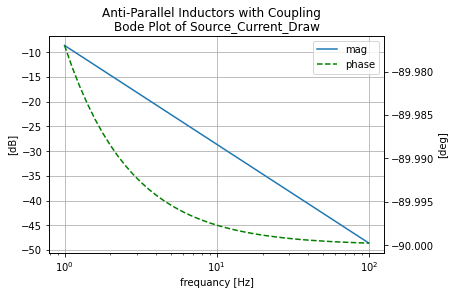

In [34]:
anylsis_k=mutual_tester(circ_k, 'Anti-Parallel Inductors with Coupling')

### Equivalent Single Inductor

In [35]:
reset()
#create the nets
net_in=Net('In')

#create a 1V AC test source and dummy R and attache to nets
vs=SINEV(ac_magnitude=1@u_V)
rdummy=R(ref='dummy', value=0@u_Ohm)
vs['p', 'n']+=rdummy[1], gnd
rdummy[2]+=net_in

l1=L(value=1@u_H)
net_in & l1[1, 2] & gnd

#k=K(ind1=l1, ind2=l2, coupling=0.5)

circ_eq=generate_netlist()
print(circ_eq)

.title 
V1 N_1 0 DC 0V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)
Rdummy N_1 In 0Ohm
L1 In 0 1H




No errors or warnings found during netlist generation.



,Start_freq,Stop_Freq,SamplingInc,StepType
0,1 Hz,100 Hz,20,decade


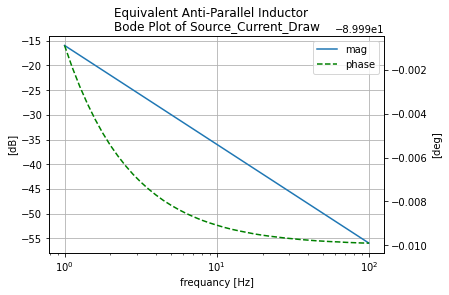

In [36]:
anylsis_eq=mutual_tester(circ_eq, 'Equivalent Anti-Parallel Inductor')

### Compersion between all three cases

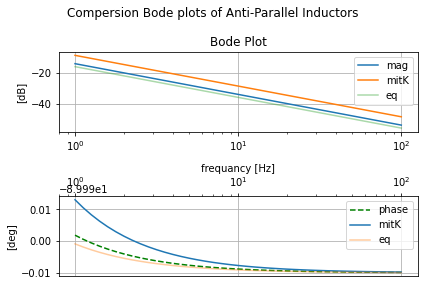

In [37]:
#compare without K, with K, theoretical equivalent 
comp_plot=eecomplex_plot_templets()
fig, [ax_mag, ax_phase]=plt.subplots(ncols=1, nrows=2)
comp_plot.bode_plot_two_templet(anylsis_nok.ac_sim_mag_DF.index,
                               anylsis_nok.ac_sim_mag_DF['V1_[A][dB]'],
                               anylsis_nok.ac_sim_phase_DF['V1_[A][deg]'],
                        axs=[ax_mag, ax_phase]
                               )
ax_mag.semilogx(anylsis_k.ac_sim_mag_DF.index, anylsis_k.ac_sim_mag_DF['V1_[A][dB]'], label='mitK')
ax_phase.semilogx(anylsis_k.ac_sim_mag_DF.index, anylsis_k.ac_sim_phase_DF['V1_[A][deg]'], label='mitK')


ax_mag.semilogx(anylsis_eq.ac_sim_mag_DF.index, anylsis_eq.ac_sim_mag_DF['V1_[A][dB]'], alpha=.4, label="eq")
ax_phase.semilogx(anylsis_eq.ac_sim_mag_DF.index, anylsis_eq.ac_sim_phase_DF['V1_[A][deg]'], alpha=.4, label='eq')

ax_mag.legend()
ax_phase.legend()

plt.suptitle('Compersion Bode plots of Anti-Parallel Inductors')
plt.tight_layout();

# Purposely designed Mutual Inductive Element; The Razivi T-Coil

So, the question that should be asked is when does mutual induction come into play outside of transformers. From a field’s standpoint, mutual induction can be used in testing the effect of placing inductors too close to each other in layout by extracting $k$ from the field simulation. But it does have uses. One of which that shows up a lot in high-speed SERDES is the Razivi T-Coil where a paper on the topology can be found there: [The Bridged T-Coil](https://www.seas.ucla.edu/brweb/papers/Journals/BRFall15TCoil.pdf).

A study of a variation of the T-coil was given by Jordan Edmunds in a two-part YT video on the subject. Where we will recreate the example from part two.


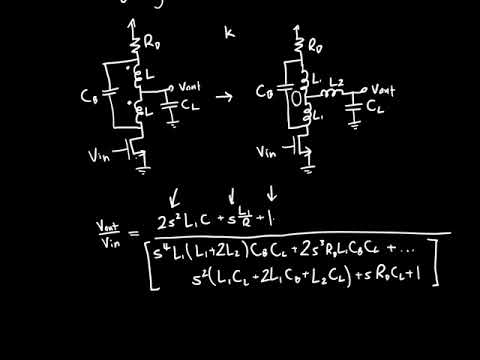

In [38]:
YouTubeVideo('-kSSMOAhlwU', width=500, height=400)

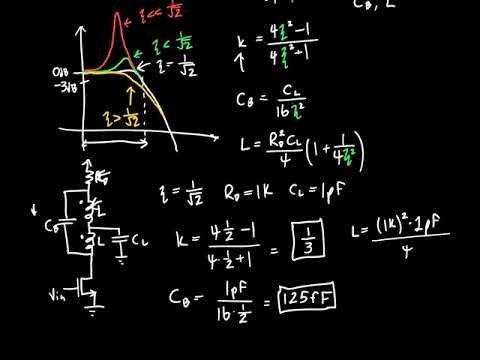

In [39]:
YouTubeVideo('vr2oYehKC8Q', width=500, height=400)

In [40]:
#%%writefile -a AC_2_Codes.py
#chapteer 2 section 3 t_coil class
#class with lcapy and skidl subcircuit to create a T-coil from https://youtu.be/vr2oYehKC8Q

class t_coil():
    def __init__(self, subcirc_ref=None, L_value=375@u_nH, K_value=1.0/3.0, CB_value=.125@u_pF, CL_value=1@u_pF):
        """
        T-Coil example from https://youtu.be/vr2oYehKC8Q example
        
        Args:
            subcirc_ref (str): reference to use for the base of the internal elements
            L_value (float; 375@u_nH; Henerys):  inductance of each of the two inductors in the T-coil
            K_value (float; 1/3): the magnetic coupling between the two inductors
            CB_value (float; .125@u_pF; Farads): capacitance of the bridge capacitor between the two coils
            CL_value (float; 1@u_pF; Farads): capacitance of the shunt capacitor between the two cols
        
        Returns:
            None
        TODO:
            -add assertions

        """
        
        self.subcirc_ref=subcirc_ref
        self.L_value=L_value
        self.K_value=K_value
        self.CB_value=CB_value
        self.CL_value=CL_value
    
    @subcircuit
    def SKiDl(self, term_0, term_1, term_2, term_3, return_elements=False):
        """
        Terminals:
        term_0, term_1, term_2, term_3
        
        Terminals are defined via:
        ```
        Left_Termanals - T-coil - Right_Termanals
                             +----+  
        Postive V_i   term_0-|0  2|-term_2     Postive V_o
        Negtive V_i   term_1-|1  3|-term_3     Negtive V_o
                             +----+
        ```
        
        Args:
            return_internls (bool; False): If True return out the internal Voltage Source,
                and Resistance objects in this package
        Returns:
            Returns elements to circuit RC lowpass filter part element object and if `return_internls`
            is True will return the internal voltage and resistance objects in that order 
        """
        if self.subcirc_ref!=None:
            CBref={'ref':f'CB_{self.subcirc_ref}'}
            CLref={'ref':f'CL_{self.subcirc_ref}'}
            LLref={'ref':f'LL_{self.subcirc_ref}'}
            LRref={'ref':f'LR_{self.subcirc_ref}'}
        
        else:
            CBref={}
            CLref={}
            LLref={}
            LRref={}
        
        self.cb=C(value=self.CB_value, **CBref)
        self.cl=C(value=self.CL_value, **CLref)
        self.ll=L(value=self.L_value, **LLref)
        self.lr=L(value=self.L_value, **LRref)
        self.mul=K(ind1=self.ll, ind2=self.lr, coupling=self.K_value)
        
        term_0 & self.ll[2, 1]  & self.lr[2, 1] & term_2
        self.cb['p', 'n']+=term_0, term_2
        self.cl['p', 'n']+=self.ll[1], term_1
        term_1+=term_3
        
        if return_elements:
            return self.cb, self.cl, self.ll, self.lr, self.mul
        
        
        
        
    def lcapy_self(self, draw_me=True, with_values=True):
        """
        Creates a lcapy schematic of this classes filter that
        can be used for amongst other things: draw a basic schematic
        of this class circuit, extract the transfer function, 
        extract the 2Port Representation
        
        Args:
            draw_me (bool): will draw a schematic of this classes circuit schematic
            
            with_values (bool): will push the filters element values into
                the resulting lcapy circuit object in place of abstract simply variables
            
        Return:
            the lcapys circuit object is stored in `self.schematic` and will
            have abstract sympy variable for the elements if `with_values` is False
            and will draw the schematic of just this classes filter if `draw_me` is True
        
        TODO:
            - Figure out how to add the K dots
            - get the Vin statement into the schematic
        
        """
        self.with_values=with_values
        
        
        self.schematic=kiwi.Circuit()
        self.schematic.add('W 1 1_1; right=2')
        self.schematic.add('W 0 0_1; right')
        
        self.schematic.add('Ll N1 0_1; left')
        self.schematic.add('Lr N1 2_1; right')
        self.schematic.add('Cl N1 1_1; down')
        
        self.schematic.add('W 0_1 0_2; up')
        self.schematic.add('W 2_1 2_2; up')
        self.schematic.add('Cb 0_2 2_2; right')
        
        self.schematic.add('W 2_1 2; right=1.5')
        self.schematic.add('W 1_1 3; right=1.5')
        self.schematic.add('P2 2 3; down, v=V_o')
        
        
        if with_values:
            self.schematic=self.schematic.subs({
                'Ll':self.L_value,
                'Lr':self.L_value,
                'Cl':self.CL_value,
                'Cb':self.CB_value})
        
        if draw_me:
            self.schematic.draw()
    
    def get_tf(self, with_values=True, ZPK=True):
        """
        will extract the symbolic transfer function for this filter
        
        Args:
            with_values (bool): will push the filters element values into
                the resulting lcapy circuit object in place of abstract sympy variables
            
            ZPK (bool): if True will try to return the TF in zero-pole-gain form
                else will try to return the TF in canonical form 
                where the unity coefficient is the highest power of the denominator
        
        """
        self.lcapy_self(draw_me=False, with_values=with_values)
        self.tf=self.schematic.transfer(0, 1, 2, 3)
        
        if ZPK:
            return self.tf.ZPK()
        else:
            return self.tf.canonical()
        
    def get_twoPort(self, network_rep='Y', with_values=True):
        """
        Gets the 2Port network representation of this filter.
        The 2Port representation can be controlled
        
        Args:
            network_rep (str; 'Y'): control string for what
                representation is used to choose from:
                
                'Z': two-port Z-parameters matrix
                'Y': two-port Y-parameters matrix
                'H': two-port H-parameters matrix
                'G': two-port G-parameters matrix
                'ABCD': two-port A-parameters matrix
                'invABCD': two-port B-parameters matrix
                'S': two-port S-parameters matrix
                'T': two-port T-parameters matrix
                
                
        """
        
        self.lcapy_self(draw_me=False, with_values=with_values)
        
        #create an action dict to get the 2P rep
        rep_actions={
            'Z':lambda x: x.Zparams(0, 1, 2, 1),
            'Y':lambda x: x.Yparams(0, 1, 2, 1), 
            'H':lambda x: x.Hparams(0, 1, 2, 1),
            'G':lambda x: x.Gparams(0, 1, 2, 1),
            'ABCD':lambda x: x.Aparams(0, 1, 2, 1),
            'invABCD':lambda x: x.Bparams(0, 1, 2, 1),
            'S':lambda x: x.Sparams(0, 1, 2, 1),
            'T':lambda x: x.Tparams(0, 1, 2, 1),
        }
        
        assert network_rep in rep_actions.keys(), f'`{network_rep}` is not 2Port rep'
        
        return rep_actions[network_rep](self.schematic)


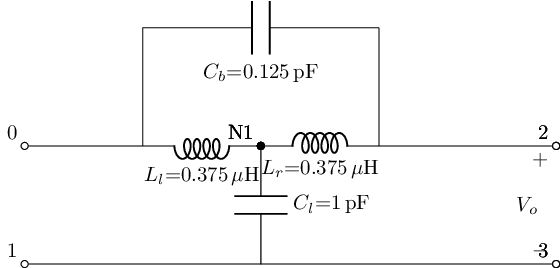

In [41]:
T_coil=t_coil()
T_coil.lcapy_self()

In [42]:
#get this filters abstract transfer function
T_coil.get_tf(with_values=False, ZPK=False)

               2       2                        
        4     s       s          1              
       s  + ───── + ───── + ────────────        
            Cₗ⋅Lᵣ   Cₗ⋅Lₗ   C_b⋅Cₗ⋅Lₗ⋅Lᵣ        
────────────────────────────────────────────────
      2                                         
 4   s ⋅(C_b⋅Lₗ + C_b⋅Lᵣ + Cₗ⋅Lₗ)        1      
s  + ──────────────────────────── + ────────────
             C_b⋅Cₗ⋅Lₗ⋅Lᵣ           C_b⋅Cₗ⋅Lₗ⋅Lᵣ

In [43]:
#get this filters transfer function
T_coil.get_tf(with_values=True, ZPK=False)

                           2                                          
 4   16000000000000000000⋅s    512000000000000000000000000000000000000
s  + ─────────────────────── + ───────────────────────────────────────
                3                                 9                   
──────────────────────────────────────────────────────────────────────
                           2                                          
 4   80000000000000000000⋅s    512000000000000000000000000000000000000
s  + ─────────────────────── + ───────────────────────────────────────
                3                                 9                   

In [44]:
reset()
#create the nets
net_in=Net('In'); net_out=Net('Out')

#create a 1V AC test source and dummy R and attache to nets
vs=SINEV(ac_magnitude=1@u_V)
rdummy=R(ref='dummy', value=0@u_Ohm)
vs['p', 'n']+=rdummy[1], gnd
rdummy[2]+=net_in

T_coil.SKiDl(net_in, gnd, net_out, gnd)

circ=generate_netlist()
print(circ)

.title 
V1 N_1 0 DC 0V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)
Rdummy N_1 In 0Ohm
C1 In Out 0.125pF
C2 N_2 0 1pF
L1 N_2 In 375nH
L2 Out N_2 375nH
K1 L1 L2 0.3333333333333333




No errors or warnings found during netlist generation.



,Start_freq,Stop_Freq,SamplingInc,StepType
0,1e+07,1e+10,20,decade


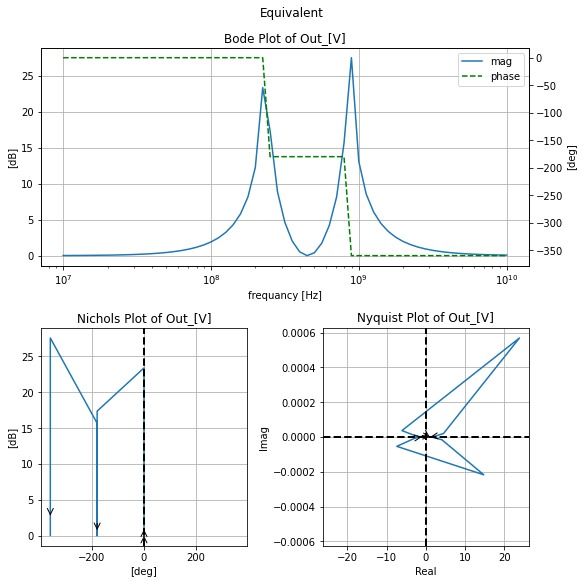

In [45]:
t_coil_resp=qfilter_explorer(circ, 'Equivalent', start_freq=1e7, stop_freq=1e10)

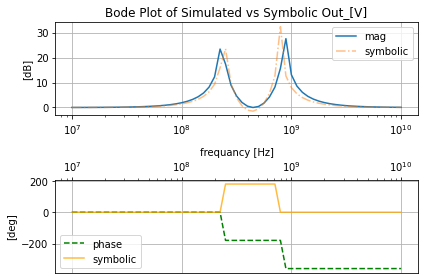

In [46]:
t_coil_resp.symbolic_tf(T_coil)

# Transformers

Am just doing a basic transformer with XSPICE will come back and do the specialty ones at a later time

## Basic Transformer with XSPICE¶

With just SPICE the transformer is modeled as a pair of coupled inductors with a coupling constant between them. So this doesn't work well for transformers. Yes, we could do it this way but it would be a laughable facsimile to a real transformer with real cores. And again SPICE is not a field solver. So to increase the capability of SPICE more advanced models have been developed. Unfortunately, most of these SPICE enhancements get swallowed up by proprietary EDA companies. But there is a major extension to Berkely's SPICE (what the core of ngspice is based on) via the Georgia Tech Research Institute that is open source and has been integrated into ngspice; XSPICE.

Here we will just start using XSPICE to create a very simple implementation of a transformer based on what is in the ngspice documentation. But of course, we will do this with SKiDl and wrap it in a class that can give a user or developer a template to bespoke it to their needs.


## Quick rundown on instantiating XSPICE elements with SKiDl

While XSPICE has a whole part of the ngspice manual dedicated to it (typically Part 2) the basic XSPICE elements are typically documented in Part 1 Chapter 12 "Mixed-Mode and Behavioral Modeling with XSPICE". The important parts of that chapter are "Table 12.1: Port Type Modifiers" and Section 12.5 "Predefined Node Types for event-driven simulation". The rest of the chapter is broken down into three main sections:

-	Analog Models (12.2): these are XSPICE elements with both analog input and outputs like Diodes, S-Domain Transfer Functions, Memristors, etc

-	Hybrid Models (12.3): these are XSPICE elements with a mixture of analog and digital IOs such as DAC, ADC, Controlled Digital Oscillators

-	Digital Models (12.4): there XSPICE elements with full digital IOs such as RTL logic primitives of AND, NAND, NOR, Latches, and Flip-Flops

To create the primitive XSPICE transformer we are going to need two XSPICE *Inductive Coupling* elements (12.2.18) and one XSPICE *Magnetic Core* element (12.2.19)

Let's just do a walkthrough of invoking an *Inductive Coupling* element in SKiDl. First off in the ngspice documentation all XSPICE elements are documented with a three-column table where at the top of the table we get some basic info for the element. What we are after here is the **Spice_Model_Name** row which in this case is `lcouple`. This tells the engine what XSPICE element were using like how `V` tells the engine that the element is a voltage source. The next main section in the table is the Port description *PORT_TABLE* where for each port it has an entry. Notice for an lcouple element it has two ports `l` and `mmf_out` in the center and far left column respectively. For each port, the most important info is **Allowed_Types** were to understand the cryptic type codes we need to refer to "Table 12.1: Port Type Modifiers". For `l` we have two allowed types `h` which is a single-ended input referenced to ground, and `hd` which is a differential input with no reference. Here's the thing, the translation from SKiDl though PySPICE to ngspice will not infer the grounded connection therefore go with the high number of terminals. So in this case port `l` will have two terminals where we are free to make the names of them whatever we want, will go with `io1` and `io2` respectively, but that is your choice though the DOT will go with the first terminal. For the other port `mmf_out` it is only a hd port so we have to create two terminals for it that again can be arbitrarily named but we will go with `mmf1`, `mmf2` here. This is the port that outputs the magnetic flux "current" to another lcouple element or magnetic core element. The last section is the *PARAMETER_TABLE* which can be quite extensive, but for the lcouple element is just a single parameter. Where each parameter will have info about its type, default value, bounds, etc. Where that can, and in our transformer class, used to write the parameter assertions. For an lcouple element, the only parameter is `num_turns` which is the number of turns for that particular lcouple element. Which, we will write the assertion to be that `num_turns` must be an integer greater than or equal to 1. Armed with the info we need to invoke our element lets look at doing so with SKiDl

The follwing will be a non function cirucit to demnstrate instaint xarray elements with SKiDl before the exstaince class for a full transfomer. We start by create a varibel that holds the number of turns for this inductor and follow it up with an assertion to make sure only valid inputs are allowed

In [47]:
#var to hold the number of turns
N_turns=5
#assertion
assert isinstance(N_turns, int) and N_turns>=1, 'N_turns must be int >=1'

We then instantiate the lcouple instance and tie it into the circuit as follows and then dissect what was done

In [48]:
#refrance lines number in markdown below don't change them
reset()
#create some dummy nets 
io1_dnet=Net('io1D'); io2_dnet=Net('io2D'); mmf1_dnet=Net('mmf1D'); mmf2_dnet=Net('mmf1D')

#instatine the XSPICE lcouple elment
l_couple_ex = A( # `A` is the ngspice control leter for XSPICE elements
            io="io1, io2, mmf1, mmf2",  #io1 & io2 \in port`l` and `mmf1` & `mmf2` \in port `mmf_out`
            model=XspiceModel( #`model` is filling in the blank for a `A` element and `XspiceModel` for SkiDl
                "ex_lcouple", #name for this element instance
                "lcouple", #what type of XSPICE element this is
                num_turns=N_turns #element parameters as kwargs
            ),
        )

#tie in the lcouple element to the nets
#first tie to the circuit
l_couple_ex['io1', 'io2']+=io1_dnet, io2_dnet
#second tie for the flux
l_couple_ex['mmf1', 'mmf2']+=mmf1_dnet, mmf2_dnet

circ=generate_netlist()
print(circ)


Pin A1/0/io1/UNSPECIFIED True
Pin A1/1/io2/UNSPECIFIED True
Pin A1/2/mmf1/UNSPECIFIED True
Pin A1/3/mmf2/UNSPECIFIED True
.title 
A1 io1D io2D mmf1D mmf1D_1 ex_lcouple
.model ex_lcouple lcouple (num_turns=5)




No errors or warnings found during netlist generation.



In line 7 we instantiate the XSPICE element within a SPICE element type `A`. This is followed up in line 8 with the declaration/creation of the IO terminals. The first port `l` is a `hd` type port therefore differential terminals are appropriately instantiated as `io1` & `io2` followed with port `mmf_out` which is only a `hd` type and so has the arbitrary terminals `mmf1` & `mmf2`. Both these ports are done in one string `"io1, io2, mmf1, mmf2"`. Next in line 9, we invoke `model=XspiceModel` where XspiceModel is the pass-through handler from SKiDl through to the ngspice netlist. The first argument of `XspiceModel` is the name of this element instance in line 10 `ex_lcouple`; where for the full transformer below this will be more descriptive with `primary` and `secondary` to indicate which lcouple element is taking on wich role. The next argument of `XspiceModel` in line 11 must be the **Spice_Model_Name** from the elements document table in the ngspice manual where for a lcouple it's lcouple. The rest of the arguments are pythonic kwags inputs where the argument is the parameter verbatim of its **Parameter_Name:** in the documentation table then set equal to the value we want it to take. In lcouple elements, there is only a single parameter `num_turns` that we set equal to our variable `N_turns` in line 12. From there we have a now standard SkiDl element that we attach to the rest of the circuit like normal. Thou what actually attaches to what is dictated by the port type and what it's meant to do. For a lcouple element port `mmf_out` which is made of terminals `mmf1` & `mmf2` is intended to pass a representation of the magnetic flux to either another lcouples `mmf_out` port or to a magnetic core element.

## XSPICE made primitive Transformer

Now know how to translate an XSPICE element from the ngspice docs to a SKiDl element. We now construct a class to act as a very primitive transformer model. And by primitive we mean it does not take into account the resistive and capacitive nature of each of the ports that must be modeled for a more sophisticated transformer model. All the values and basic configuration are taken from the ngspice 32 manual section 12.2.19 examples


In [49]:
#%%writefile -a AC_2_Codes.py
#chapteer 2 section 3 basic_xspice_transformer class
#class with skidl subcircuit to create primitive XSPICE transformer-based
#on the ex in ngspice 32 manual section 12.2.19

class basic_xspice_transformer():
    """
    Basic XSPICE based two-port transformer based on the example
    in ngspice 32 manual section 12.2.19
    """
    
    def __init__(self, subcirc_ref=None, prim_turns=1, sec_turns=1, parallel=True):
        """
        Create a primitive two-port transformer with a magnetic core
        where core parameters are set in `self.core_specs`
        
       Args:
            subcirc_ref (str): reference to use for the base of the internal elements
            prim_turns (int; 1; None): the number of turns on the primary port 
                of the transformer must be an int >=1
            
            sec_turns (int; 1; None): the number of turns on the primary port 
                of the transformer must be an int >=1
            
            parallel (bool; True): If True will put the primary and secondary ports
                in parallel dot configuration else will put them in anti- parallel config
            
        Returns:
            None
        TODO:
            -really investigate the anti parrel config to make sure it's working
                as it's supposed to

    
        """
        self.subcirc_ref=subcirc_ref
        
        assert prim_turns>=1 and sec_turns>=1, 'turns must be >= 1'
        self.prim_turns=prim_turns; self.sec_turns=sec_turns
        
        self.parallel=parallel
        
        self.core_specs()
    
    def core_specs(self, 
                   H_array=None, B_array=None, 
                   area=0.01, length=0.01, 
                   input_domain=0.01, 
                   fraction=True, 
                   mode=1, 
                   in_low=-7.0, in_high=7.0,
                   hyst=2.3, out_lower_limit=-2.5e-4,
                   out_upper_limit=2.5e-4,
                  #tried to make it look like the table in the ngspice manual
                  make_plot=False):
        """
        Access method to set all the core properties, if `make_plot` is true 
        will produce a plot of the BH curve
        
        Args:
        (see assertions in code below for each inputs constraints)
        (default values are taken from the two examples in ngspice 32 12.2.19,
        not from the default values in `core`'s docs )
        
            H_array (np.array/None; None; ATurns/m): array for the core's main BH curve H values
             if None will use default in the ngspice 32 manual examples in 12.2.19;
             used only in pwl mode
            
            B_array (np.array/None; None; T):array for the core's main BH curve B values
             if None will use default in the ngspice 32 manual examples in 12.2.19; 
             used only in pwl mode
            
            area (float; 0.01; m^2): the cross-section area of the core such that the flux
                will be \psi=B *A where A is the area and B is the B part of the BH curve; 
                used only in pwl mode
                
            length (float; 0.01; m): length of the core will scall the io mmf such that
            H=mmf/L where H is the H part of the BH curve, mmf is the IO mmf and L is the length; 
            used only in pwl mode
            
            input_domain (float; 0.01; ?): docs are not clear what this is
            
            fraction (bool; True): if True apply smoothing to the BH curve vs nearest value in BH curve array
            
            mode (int; 1): if `1` use a pwl model of the core else `2` use a hysteresis model
            
            in_low (float; -7.0; ?): input low value, ?; used only when using hysteresis mode
            
            in_high (float; 7.0; ?): input high value, ?; used only when using hysteresis mode
            
            hyst (float; 2.3; ?): hysteresis, ?; used only when using hysteresis mode
            
            out_lower_limit (float; -2.5e-4; ?): ouput lower limit. ? ; used only when using hysteresis 
            
            out_upper_limit (float; 2.5e-4; ?): ouput upper limit, ? ; used only when using hysteresis 
            
            make_plot (bool; False): if True create a plot of the BH curve and
                returns that plots axis
            
        
        Returns:
            create atriputes of XSPICE core parmaters like `self.*_V` that 
            hold the parmter value to pass to the core instaince in `self.SKiDl`.
            If `make_plot` is True will create plot of BH curve and retrun it's axis
            
        
        TODO:
            - beef up the docs about the hysteresis from a source other then the ngspice manual
            - beef up the plots
        
        
        """
        
        if (H_array==None) or (B_array==None):
            assert (H_array is None) and (B_array is None), 'Both H & B must be None or equal np.arrays'
            H_array=np.array([-1000, -500, -375, -250, -188, -125, -63, 0, 63, 125, 188, 250, 375, 500, 1000])
            B_array=np.array([-3.13e-3, -2.63e-3, -2.33e-3, -1.93e-3, -1.5e-3, -6.25e-4, -2.5e-4, 0, 2.5e-4, 6.25e-4, 1.5e-3, 1.93e-3, 2.33e-3, 2.63e-3, 3.13e-3])
        else:
            assert isinstance(H_array, (np.ndarray, np.generic) ) and isinstance(H_array, (np.ndarray, np.generic) ), 'Both H & B must be None or eual np.arrays'
        
        assert (H_array.shape==B_array.shape) and (H_array.shape[0]>1) and (H_array.ndim==1), 'H and B arrays must be eual 1 dim arrays'
        self.H_array_V=H_array; self.B_array_V=B_array  
        
        assert isinstance(area, float) and (area>=0), 'area must be a float >=0'
        self.area_V=area
        
        assert isinstance(length, float) and (length>=0), 'length must be a float >=0'
        self.length_V=length
        
        assert isinstance(input_domain, float) and (input_domain>=1e-12) and (input_domain<=0.5), 'input_domain must be a float >=1e-12 and <=0.5'
        self.input_domain_V=input_domain
        
        assert isinstance(fraction, bool), 'fraction must be a bool'
        self.fraction_V=fraction
        
        assert mode in [1,2], 'mode is a control value 1:pwl, 2:hyst; only'
        self.mode_V=mode
        
        assert isinstance(in_low, float) and (in_low<in_high), 'in_low must be a float less then in_high'
        self.in_low_V=in_low
        
        assert isinstance(in_high, float) and (in_low<in_high), 'in_high must be a float greater then in_low'
        self.in_high_V=in_high
        
        assert isinstance(hyst, float) and (hyst>0.0), 'hyst must be a float greater than 0'
        self.hyst_V=hyst
        
        assert isinstance(out_lower_limit, float) and (out_lower_limit<out_upper_limit), 'out_lower_limit must be a float less then in_high'
        self.out_lower_limit_V=out_lower_limit
        
        assert isinstance(out_upper_limit, float) and (out_lower_limit<out_upper_limit), 'out_upper_limit must be a float less then out_lower_limit'
        self.out_upper_limit_V=out_upper_limit
        
        
        if make_plot:
            fig, ax=plt.subplots(ncols=1, nrows=1)
            
            ax.plot(self.H_array_V, self.B_array_V, marker='o' , label='Main BH Curve')
            ax.set_xlabel('magfield_H_[ATurns/m]'); ax.set_ylabel('flux_density_B_[T]')
            ax.axvline(color='black', linestyle='--', alpha=0.5); ax.axhline(color='black', linestyle='--', alpha=0.5)
            ax.grid()
            ax.legend()
            if self.subcirc_ref==None:
                title=''
            else:
                title=self.subcirc_ref
            ax.set_title(f'B-H Curve for Transfomer {title}')
            
            return ax
    @subcircuit
    def SKiDl(self, term_0, term_1, term_2, term_3, return_elements=False):
        """
        Terminals:
        term_0, term_1, term_2, term_3
        
        Terminals are defined via:
        ```
        Left_(prime)Termanals - Transformer - Right_(sec)Termanals
                    (dot)   +--core--+  (dot if parallel)
        Postive V_i   term_0-|0 || 2|-term_2     Postive V_o
        Negtive V_i   term_1-|1 || 3|-term_3     Negtive V_o
                             +------+ (dot if anti-parallel) 
        ```
        
        Args:
            return_internls (bool; False): If True return out the internal Voltage Source,
                and Resistance objects in this package
        Returns:
            Returns elements to circuit RC lowpass filter part element object and if `return_internls`
            is True will return the internal voltage and resistance objects in that order 
        """
        
        # Creating an XSPICE part using the SPICE abbreviation 'A'.
        #Createing the primary side
        prim = A(
            io="io1, io2, mmf1, mmf2",  #io1 & io2 \in port`l` and `mmf1` & `mmf2` \in port `mmf_out`
            model=XspiceModel(
                f"prim_{self.subcirc_ref}",
                "lcouple",
                num_turns=self.prim_turns
            ),
        )
        
        #creating the secondary side
        sec = A(
            io="io1, io2, mmf1, mmf2", 
            model=XspiceModel(
                f"sec_{self.subcirc_ref}",
                "lcouple",
                num_turns=self.sec_turns
            ),
        )
        
        #connect the "inductors" to the outside world
        #the lcouples did not like having their ports named just 1, 2
        prim['io1', 'io2']+=term_0, term_1
        if self.parallel:
            sec['io1', 'io2']+=term_2, term_3
        else:
            sec['io2', 'io1']+=term_2, term_3
        
        
        #instatnint the core
        core=A(
            io="top, bot", #couldnt think of a better i/o name 
            model=XspiceModel(
                f'core_{self.subcirc_ref}',
                'core',
                H_array=self.H_array_V.tolist(),
                B_array=self.H_array_V.tolist(),
                area=self.area_V,
                length=self.length_V,
                input_domain=self.input_domain_V,
                fraction=self.fraction_V,
                mode=self.mode_V,
                in_low=self.in_low_V,
                in_high=self.in_high_V,
                hyst=self.hyst_V,
                out_lower_limit=self.out_lower_limit_V,
                out_upper_limit=self.out_upper_limit_V

            )
        )
        
        
        #connect the core to the mmf control i/o for the lcoupled inductors
        #direct connect of the `mmfs`'s together yield singular matrix, gnd should be fine
        prim['mmf1', 'mmf2']+=core['top'], gnd
        if self.parallel:
            sec['mmf1', 'mmf2']+=core['bot'], gnd
        else:
            sec['mmf2', 'mmf1']+=core['bot'], gnd
    
    def lcapy_self(self):
        """
        leaving off all the lcapy stuff since it won't do anti parral config
        """
        pass


## Parallel Primary and Seconday configeration

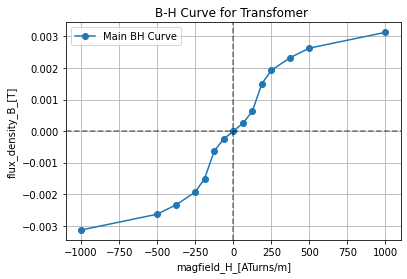

In [50]:
transformer=basic_xspice_transformer(prim_turns=2, sec_turns=5)
#dont change any core prop, but make the plot 
transformer.core_specs(make_plot=True);

In [51]:
reset()
#create the nets
net_in=Net('In'); net_out=Net('Out')

#create a 1V AC test source and dummy R and attache to nets
vs=SINEV(ac_magnitude=1@u_V)
rdummy=R(ref='dummy', value=0@u_Ohm)
vs['p', 'n']+=rdummy[1], gnd
rdummy[2]+=net_in


#conenct the subcircuit
transformer.SKiDl(net_in, gnd, net_out, gnd)

#create a load
rload=R(ref='load', value=100@u_Ohm)
load_amm=V(ref='amm_load', dc_value=0)
net_in & rload & load_amm & gnd

circ=generate_netlist(libs="SpiceLib")
print(circ)

Pin A1/0/io1/UNSPECIFIED True
Pin A1/1/io2/UNSPECIFIED True
Pin A1/2/mmf1/UNSPECIFIED True
Pin A1/3/mmf2/UNSPECIFIED True
Pin A2/0/io1/UNSPECIFIED True
Pin A2/1/io2/UNSPECIFIED True
Pin A2/2/mmf1/UNSPECIFIED True
Pin A2/3/mmf2/UNSPECIFIED True
Pin A3/0/top/UNSPECIFIED True
Pin A3/1/bot/UNSPECIFIED True
.title 
V1 N_1 0 DC 0V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)
Rdummy N_1 In 0Ohm
A1 In 0 N_2 0 prim_None
A2 Out 0 N_3 0 sec_None
A3 N_2 N_3 core_None
Rload In N_4 100Ohm
Vamm_load N_4 0 0
.model prim_None lcouple (num_turns=2)
.model sec_None lcouple (num_turns=5)
.model core_None core (B_array=[-1000, -500, -375, -250, -188, -125, -63, 0, 63, 125, 188, 250, 375, 500, 1000] H_array=[-1000, -500, -375, -250, -188, -125, -63, 0, 63, 125, 188, 250, 375, 500, 1000] area=0.01 fraction=True hyst=2.3 in_high=7.0 in_low=-7.0 input_domain=0.01 length=0.01 mode=1 out_lower_limit=-0.00025 out_upper_limit=0.00025)




No errors or warnings found during netlist generation.



In [52]:
trans_sim=ac_ease(circ)
trans_sim.ac_sweep_setup(10@u_Hz, 1@u_GHz, 20, 'decade', True)
trans_sim.do_ac_sim()
trans_sim.ac_resultsNB_DF.columns

,Start_freq,Stop_Freq,SamplingInc,StepType
0,10 Hz,1 GHz,20,decade


Index(['N_1_[V]', 'In_[V]', 'N_2_[V]', 'Out_[V]', 'N_3_[V]', 'N_4_[V]',
       'V1_[A]', 'Vamm_load_[A]'],
      dtype='object')

In [53]:
par_data=ac_representation_tool(trans_sim.ac_resultsNB_DF)
par_data.make_mag_phase()

/home/iridium/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [54]:
par_data.ac_sim_mag_DF.columns

Index(['N_1_[V][dB]', 'In_[V][dB]', 'N_2_[V][dB]', 'Out_[V][dB]',
       'N_3_[V][dB]', 'N_4_[V][dB]', 'V1_[A][dB]', 'Vamm_load_[A][dB]'],
      dtype='object')

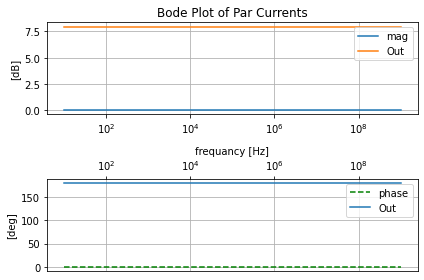

In [55]:
par_plot=eecomplex_plot_templets()
fig, [axmag, axphase]=plt.subplots(ncols=1, nrows=2)
par_plot.bode_plot_two_templet(par_data.ac_sim_mag_DF.index, 
                               par_data.ac_sim_mag_DF['In_[V][dB]'], par_data.ac_sim_phase_DF['In_[V][deg]'],
                              axs=[axmag, axphase], title='Par Currents')

axmag.semilogx(par_data.ac_sim_mag_DF.index, par_data.ac_sim_mag_DF['Out_[V][dB]'], label='Out')
axphase.semilogx(par_data.ac_sim_mag_DF.index, par_data.ac_sim_phase_DF['Out_[V][deg]'], label='Out')

axmag.legend(); axphase.legend()
plt.tight_layout()

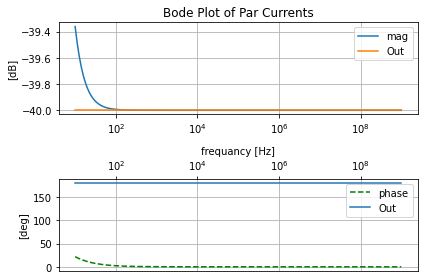

In [56]:
par_plot=eecomplex_plot_templets()
fig, [axmag, axphase]=plt.subplots(ncols=1, nrows=2)
par_plot.bode_plot_two_templet(par_data.ac_sim_mag_DF.index, 
                               par_data.ac_sim_mag_DF['V1_[A][dB]'], par_data.ac_sim_phase_DF['V1_[A][deg]'],
                              axs=[axmag, axphase], title='Par Currents')

axmag.semilogx(par_data.ac_sim_mag_DF.index, par_data.ac_sim_mag_DF['Vamm_load_[A][dB]'], label='Out')
axphase.semilogx(par_data.ac_sim_mag_DF.index, par_data.ac_sim_phase_DF['Vamm_load_[A][deg]'], label='Out')

axmag.legend(); axphase.legend()
plt.tight_layout()

## Anti-Parallel Primary and Secondary configuration

Need to verify this better with a transient simulation.

In [57]:
transformer=basic_xspice_transformer(prim_turns=2, sec_turns=5, parallel=False)

In [58]:
reset()
#create the nets
net_in=Net('In'); net_out=Net('Out')

#create a 1V AC test source and dummy R and attache to nets
vs=SINEV(ac_magnitude=1@u_V)
rdummy=R(ref='dummy', value=0@u_Ohm)
vs['p', 'n']+=rdummy[1], gnd
rdummy[2]+=net_in


#conenct the subcircuit
transformer.SKiDl(net_in, gnd, net_out, gnd)

#create a load
rload=R(ref='load', value=100@u_Ohm)
load_amm=V(ref='amm_load', dc_value=0)
net_in & rload & load_amm & gnd

circ=generate_netlist(libs="SpiceLib")
print(circ)

Pin A1/0/io1/UNSPECIFIED True
Pin A1/1/io2/UNSPECIFIED True
Pin A1/2/mmf1/UNSPECIFIED True
Pin A1/3/mmf2/UNSPECIFIED True
Pin A2/0/io1/UNSPECIFIED True
Pin A2/1/io2/UNSPECIFIED True
Pin A2/2/mmf1/UNSPECIFIED True
Pin A2/3/mmf2/UNSPECIFIED True
Pin A3/0/top/UNSPECIFIED True
Pin A3/1/bot/UNSPECIFIED True
.title 
V1 N_1 0 DC 0V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)
Rdummy N_1 In 0Ohm
A1 In 0 N_2 0 prim_None
A2 0 Out 0 N_3 sec_None
A3 N_2 N_3 core_None
Rload In N_4 100Ohm
Vamm_load N_4 0 0
.model prim_None lcouple (num_turns=2)
.model sec_None lcouple (num_turns=5)
.model core_None core (B_array=[-1000, -500, -375, -250, -188, -125, -63, 0, 63, 125, 188, 250, 375, 500, 1000] H_array=[-1000, -500, -375, -250, -188, -125, -63, 0, 63, 125, 188, 250, 375, 500, 1000] area=0.01 fraction=True hyst=2.3 in_high=7.0 in_low=-7.0 input_domain=0.01 length=0.01 mode=1 out_lower_limit=-0.00025 out_upper_limit=0.00025)




No errors or warnings found during netlist generation.



In [59]:
trans_sim=ac_ease(circ)
trans_sim.ac_sweep_setup(10@u_Hz, 1@u_GHz, 20, 'decade', True)
trans_sim.do_ac_sim()
trans_sim.ac_resultsNB_DF.columns

,Start_freq,Stop_Freq,SamplingInc,StepType
0,10 Hz,1 GHz,20,decade


Index(['N_1_[V]', 'In_[V]', 'N_2_[V]', 'Out_[V]', 'N_3_[V]', 'N_4_[V]',
       'V1_[A]', 'Vamm_load_[A]'],
      dtype='object')

In [60]:
antipar_data=ac_representation_tool(trans_sim.ac_resultsNB_DF)
antipar_data.make_mag_phase()

/home/iridium/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [61]:
antipar_data.ac_sim_mag_DF.columns

Index(['N_1_[V][dB]', 'In_[V][dB]', 'N_2_[V][dB]', 'Out_[V][dB]',
       'N_3_[V][dB]', 'N_4_[V][dB]', 'V1_[A][dB]', 'Vamm_load_[A][dB]'],
      dtype='object')

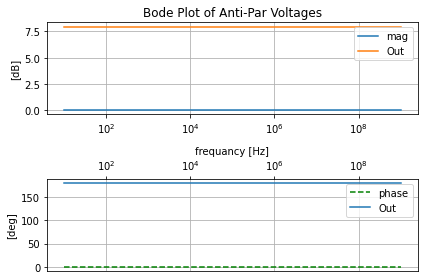

In [62]:
par_plot=eecomplex_plot_templets()
fig, [axmag, axphase]=plt.subplots(ncols=1, nrows=2)
par_plot.bode_plot_two_templet(antipar_data.ac_sim_mag_DF.index, 
                               antipar_data.ac_sim_mag_DF['In_[V][dB]'], antipar_data.ac_sim_phase_DF['In_[V][deg]'],
                              axs=[axmag, axphase], title='Anti-Par Voltages')

axmag.semilogx(antipar_data.ac_sim_mag_DF.index, antipar_data.ac_sim_mag_DF['Out_[V][dB]'], label='Out')
axphase.semilogx(antipar_data.ac_sim_mag_DF.index, antipar_data.ac_sim_phase_DF['Out_[V][deg]'], label='Out')

axmag.legend(); axphase.legend()
plt.tight_layout()

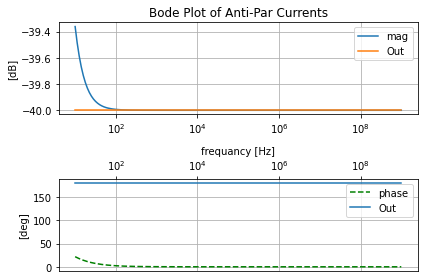

In [63]:
par_plot=eecomplex_plot_templets()
fig, [axmag, axphase]=plt.subplots(ncols=1, nrows=2)
par_plot.bode_plot_two_templet(antipar_data.ac_sim_mag_DF.index, 
                               antipar_data.ac_sim_mag_DF['V1_[A][dB]'], antipar_data.ac_sim_phase_DF['V1_[A][deg]'],
                              axs=[axmag, axphase], title='Anti-Par Currents')

axmag.semilogx(antipar_data.ac_sim_mag_DF.index, antipar_data.ac_sim_mag_DF['Vamm_load_[A][dB]'], label='Out')
axphase.semilogx(antipar_data.ac_sim_mag_DF.index, antipar_data.ac_sim_phase_DF['Vamm_load_[A][deg]'], label='Out')

axmag.legend(); axphase.legend()
plt.tight_layout()

## Autotransformer

## Isolation 

https://www.allaboutcircuits.com/technical-articles/transformer-isolation/

### Test Bench Type

### Medical Type

## Multi Winding

## Cinter-tapped

## Current Transformer

## Y-Delta Converters

# Citations

[1] ALL ABOUT ELECTRONICS. "Self Inductance and Mutual Inductance Explained," YouTube, Feb 12, 2017. [Video file]. Available: https://youtu.be/hoTInTKij0o. [Accessed: Jul 18, 2021].

[2] ALL ABOUT ELECTRONICS. "Dot Convention in Magnetically Coupled Circuits," YouTube, Feb 18, 2017. [Video file]. Available: https://youtu.be/sILgO4sQmRs. [Accessed: Jul 18, 2021].

[3] ALL ABOUT ELECTRONICS. "Mutually Coupled Inductors in Series (Derivation / Proof and Examples)," YouTube, Apr 21, 2017. [Video file]. Available: https://youtu.be/49OL_3L7BFA. [Accessed: Jul 18, 2021].

[4] ALL ABOUT ELECTRONICS. "Mutually Coupled Inductors in Parallel (Derivation / Proof and Examples)," YouTube, Apr 24, 2017. [Video file]. Available: https://youtu.be/NacczEJj_iI. [Accessed: Jul 18, 2021].

[5] B. Razavi, "The Bridged T-Coil [A Circuit for All Seasons]", IEEE Solid-State Circuits Magazine, vol. 7, no. 4, pp. 9-13, 2015. Available: 10.1109/mssc.2015.2474258 [Accessed 27 January 2021] or https://www.seas.ucla.edu/brweb/papers/Journals/BRFall15TCoil.pdf [Accessed: Jul 18, 2021].

[6] Jordan Edmunds. "Bridged T Coil Analysis Part 1 ," YouTube, Feb 23, 2018. [Video file]. Available: https://youtu.be/-kSSMOAhlwU. [Accessed: Jul 18, 2021].

[7] Jordan Edmunds. "Bridged T Coil Analysis Part 2 ," YouTube, Feb 23, 2018. [Video file]. Available: https://youtu.be/vr2oYehKC8Q. [Accessed: Jul 18, 2021].

[8] Vogt, M. Hendrix and P. Nenzi, Ngspice User’s Manual Version 32 (Describes ngspice release version), 32nd ed. 2020, Chapter 12: Mixed-Mode and Behavioral Modeling with XSPICE.
